In [1]:
import math
import data
import random
import plotly.express as px

### Part 2: Scalar backpropagation

##### Question 3

In [2]:
def forward_pass(W, V, X, t, b, c, loss=0):
    k, h = [0., 0., 0.], [0., 0., 0.]
    o, y = [0., 0.], [0., 0.]
    
    # linear
    for j in range(3):
        for i in range(2):
            k[j] += W[i][j] * X[i]
        k[j] += b[j]

    # sigmoid activation
    for i in range(3):
        h[i] = (1+math.exp(-k[i]))**(-1)

    # linear
    for i in range(2):
        for j in range(3):
            o[i] += h[j] * V[j][i]
        o[i] += c[i]

    #softmax activation
    sum_exp_output = sum([math.exp(output) for output in o])
    for i in range(2):
        y[i] = math.exp(o[i])/ sum_exp_output

    # compute loss
    for i in range(2):
        if t[i] == 1:
            loss += (-1*math.log(y[i]))

    context = W, V, X, t, b, c, k, h, o, y
    return loss, context

In [3]:
def backward_pass(context, alpha=0.01):
    W, V, X, t, b, c, k, h, o, y = context
    index_tc = t.index(max(t)) # index of the true class in instances
    dy, do = [0., 0.], [0., 0.]
    dV, dW = [[0., 0.], [0., 0.], [0., 0.]], [[0., 0. , 0.], [0., 0., 0.]]
    dh, dk = [0. , 0., 0.], [0. , 0., 0.]
    db = [0., 0., 0.]

    # compute d(Loss)/dy[i]
    for i in range(2):
        if t[i] == 1: dy[i] = -1/y[i]
        else: dy[i] = 0

    # compute d(Loss)/do[i]
    for i in range(2):
        for j in range(2):
            if i != j and i == index_tc:
                do[j] += dy[i]*(-1)*y[i]*y[j]
            elif i == j and i == index_tc:
                do[j] += dy[i]*y[i]*(1-y[i])
            elif i != index_tc:
                do[j] += 0

    # compute d(Loss)/dV[j][i] and d(Loss)/dh[i]
    for i in range(2):
        for j in range(3): 
            dV[j][i] = do[i]*h[j]
            dh[j] += do[i]*V[j][i]
    dc = do

    # compute d(Loss)/dk[i]
    for j in range(3):
        dk[j] = dh[j] * h[j] * (1-h[j])

    # compute d(Loss)/dW[i][j] and d(Loss)/db[j]
    for j in range(3):
        for i in range(2):
            dW[i][j] = dk[j] * X[i]
        db[j] = dk[j]

    for j in range(3):
        for i in range(2):
            W[i][j] += -alpha*dW[i][j]
        b[j] += -alpha*db[j]

    for i in range(2):
        for j in range(3): 
            V[j][i] += -alpha*dV[j][i]
        c[i] += -alpha*dc[i]

    results = W, V, b, c
    gradients = dy, do, dh, dk, dV, dW, db, dc
    return gradients, results

In [4]:
## Test forward pass
W, V= [[1.,1.,1.], [-1,-1,-1]], [[1.,1.], [-1.,-1.], [-1., -1.]]
b, c = [0, 0, 0], [0, 0]
X, t = [1, -1], [1, 0]
loss = 0

loss, context = forward_pass(W, V, X, t, b, c)
print("Loss: ", loss)

## Test backward pass
gradients, results = backward_pass(context)
dy, do, dh, dk, dV, dW, db, dc = gradients

print("Gradient of W: ", dW)
print("Gradient of b: ", db)
print("Gradient of V: ", dV)
print("Gradient of c: ", dc)

Loss:  0.6931471805599453
Gradient of W:  [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]
Gradient of b:  [0.0, 0.0, 0.0]
Gradient of V:  [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
Gradient of c:  [-0.5, 0.5]


##### Question 4

In [5]:
(xtrain, ytrain), (xval, yval), num_cls = data.load_synth()

In [6]:
def convert_onehotencoding(ydata):
    t = [0, 0]
    t[ydata] = 1
    return t

In [7]:
def initialize_weights(is_random=True):
    r = random.gauss # mu=0 and sigma=1
    if not is_random:
        W, V= [[1.,1.,1.], [-1,-1,-1]], [[1.,1.], [-1.,-1.], [-1., -1.]]
        b, c = [0, 0, 0], [0, 0]
    else:
        W, V= [[r(0,1),r(0,1),r(0,1)], [r(0,1),r(0,1),r(0,1)]], [[r(0,1),r(0,1)], [r(0,1),r(0,1)], [r(0,1),r(0,1)]]
        b, c = [0, 0, 0], [0, 0]
    
    return W, V, b, c

In [8]:
W, V, b, c = initialize_weights(is_random=True)

# save loss values for train and validation
avg_loss_train, avg_loss_val = [], []
loss_train_epoch1, loss_val_epoch1 = [], []
epochs = 10
alpha = 0.01 # learning rate

for epoch in range(epochs):
    # train data
    loss_train, loss_val = [], []
    for X, t_index in zip(xtrain, ytrain): 
        t = convert_onehotencoding(t_index)
        loss, context = forward_pass(W, V, list(X), t, b, c)
        
        gradients, results = backward_pass(context, alpha)
        W, V, b, c  = results

        loss, context = forward_pass(W, V, list(X), t, b, c)
        loss_train.append(loss)

    # validation data
    for X, t_index in zip(xval, yval): 
        t = convert_onehotencoding(t_index)
        loss, context = forward_pass(W, V, list(X), t, b, c)
        loss_val.append(loss)

    if epoch == 0: 
        loss_train_epoch1 = loss_train
        loss_val_epoch1 = loss_val

    avg_loss_train.append(sum(loss_train)/len(loss_train))
    avg_loss_val.append(sum(loss_val)/len(loss_val))


In [9]:
import pandas as pd

avg_loss = []
vector_epochs = [i for i in range(len(avg_loss_train))]
avg_loss += avg_loss_train
name = ['train' for _ in range(len(avg_loss_train))]
vector_epochs += [i for i in range(len(avg_loss_val))]
avg_loss += avg_loss_val
name += ['val' for _ in range(len(avg_loss_val))]

df = pd.DataFrame({'epochs': vector_epochs,'avg_loss': avg_loss, 'name': name})
fig = px.line(df, x='epochs', y='avg_loss', color='name', markers=True)
fig.show()

In [10]:
# TODO CHECK WHICH PLOT WE NEED

samples = [i for i in range(len(loss_train_epoch1))]
loss_epoch1 = loss_train_epoch1
name = ['train' for _ in range(len(loss_train_epoch1))]

df = pd.DataFrame({'samples': samples,'loss_epoch1': loss_epoch1, 'name': name})
fig = px.line(df, x='samples', y='loss_epoch1', color='name', markers=True)
fig.show()

### Part 3: Tensor backpropagation

In [18]:
import numpy as np

##### Question 5

In [13]:
(x_train, y_train), (x_val, y_val), num_mcls = data.load_mnist()

In [219]:
x_train[0].shape

(784,)

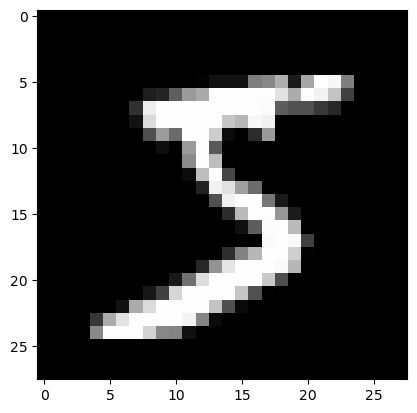

In [14]:
# visualize the data
import matplotlib.pyplot as plt

img = x_train[0,:].reshape(28,28) # First image in the training set.
plt.imshow(img,cmap='gray')
plt.show() # Show the image

In [235]:
def forward_pass_vectorized(W, V, X, t_index, b, c, nr_hlayers=300, nr_classes=10):
    k, h = np.array([0.]*nr_hlayers), np.array([0.]*nr_hlayers)
    o, y = np.array([0.]*nr_classes), np.array([0.]*nr_classes)
    
    # linear
    k = W.dot(X) + b

    # sigmoid activation
    h = (1+np.exp(-k))**(-1)

    # linear
    o = V.dot(h) + c

    # softmax activation
    exp_o = np.exp(o)
    y = exp_o/np.sum(exp_o)
    
    # compute loss
    loss = np.sum(-1*np.log(y[t_index]))

    context = W, V, X, t_index, b, c, k, h, o, y
    return loss, context

In [245]:
def backward_pass_vectorized(context, nr_hlayers= 300, nr_outputs = 10, alpha=0.01):
    W, V, X, t_index, b, c, k, h, o, y = context
    dy, do = np.array([0.]*nr_outputs), np.array([0.]*nr_outputs)
    y = np.array(y)

    # compute d(Loss)/dy[i]
    dy[t_index] = -1/y[t_index]

    # compute d(Loss)/do[i] TODO
    # https://mmuratarat.github.io/2019-01-27/derivation-of-softmax-function
    # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    for i in range(2):
        for j in range(2):
            if i != j and i == t_index:
                do[j] += dy[i]*(-1)*y[i]*y[j]
            elif i == j and i == t_index:
                do[j] += dy[i]*y[i]*(1-y[i])
            elif i != t_index:
                do[j] += 0

    # compute d(Loss)/dV[j][i] and d(Loss)/dh[i]
    dV = do[:, None] @ (h[:, None].T)
    dh = V.T @ do[:, None]
    dc = do[:, None]

    # compute d(Loss)/dk[i]
    dk = dh * h[:, None] * (1-h[:, None])

    # compute d(Loss)/dW[i][j] and d(Loss)/db[j]
    dW = dk @ X[:, None].T
    db = dk

    W += -alpha*dW
    b = b[:, None] - alpha*db
    V += -alpha*dV
    c = c[:, None] - alpha*dc

    results = W, V, b, c
    gradients = dy, do, dh, dk, dV, dW, db, dc
    return gradients, results

In [243]:
def initialize_weights(input_size, nr_classes=10, nr_hlayers=300):
    r = random.gauss # mu=0 and sigma=1
    
    W = np.array([[r(0,1)]*input_size]*nr_hlayers)
    V = np.array([[r(0,1)]*nr_hlayers]*nr_classes)
    b, c = np.array([0.]*nr_hlayers), np.array([0.]*nr_classes)
    
    return W, V, b, c

In [ ]:
# W, V= np.array([[1.,-1.], [1.,-1.], [1.,-1.]]), np.array([[1., -1, -1 ], [1., -1, -1]])
# b, c = np.array([0, 0, 0]), np.array([0, 0])
# X, t = np.array([1, -1]), np.array([1, 0])

# loss, context = forward_pass_vectorized(W, V, X, t, b, c)
# print("Loss: ", loss)

# gradients, results = backward_pass_vectorized(context)
# dy, do, dh, dk, dV, dW, db, dc = gradients

# print("Gradient of W: ", dW)
# print("Gradient of b: ", db)
# print("Gradient of V: ", dV)
# print("Gradient of c: ", dc)

Loss:  1.3862943611198906


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [250]:
W, V, b, c = initialize_weights(x_train.shape[1])

# save loss values for train and validation
avg_loss_train, avg_loss_val = [], []
loss_train_epoch1, loss_val_epoch1 = [], []
epochs = 1
alpha = 0.01 # learning rate

for epoch in range(epochs):
    # train data
    loss_train, loss_val = [], []
    for X, t_index in zip(x_train, y_train):
        X = np.array(X)
        loss, context = forward_pass_vectorized(W, V, X, t_index, b, c)

        gradients, results = backward_pass_vectorized(context)
        dy, do, dh, dk, dV, dW, db, dc = gradients
        
        loss, context = forward_pass_vectorized(W, V, X, t_index, b, c)
        loss_train.append(loss)

    # validation data
    for X, t_index in zip(xval, yval): 
        X = np.array(X)
        loss, context = forward_pass_vectorized(W, V, X, t_index, b, c)
        loss_val.append(loss)

    if epoch == 0: 
        loss_train_epoch1 = loss_train
        loss_val_epoch1 = loss_val

    avg_loss_train.append(sum(loss_train)/len(loss_train))
    avg_loss_val.append(sum(loss_val)/len(loss_val))


c:\Users\Claire\anaconda3\envs\DL_1\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:

overflow encountered in exp



ValueError: shapes (300,784) and (2,) not aligned: 784 (dim 1) != 2 (dim 0)

In [ ]:
import pandas as pd

avg_loss = []
vector_epochs = [i for i in range(len(avg_loss_train))]
avg_loss += avg_loss_train
name = ['train' for _ in range(len(avg_loss_train))]
vector_epochs += [i for i in range(len(avg_loss_val))]
avg_loss += avg_loss_val
name += ['val' for _ in range(len(avg_loss_val))]

df = pd.DataFrame({'epochs': vector_epochs,'avg_loss': avg_loss, 'name': name})
fig = px.line(df, x='epochs', y='avg_loss', color='name', markers=True)
fig.show()